# modelos ARIMA com Sazonalidade - SARIMA, possui os parâmetros P, D e Q Sazonais.

 modelos ARIMA com Sazonalidade - SARIMA, possui os parâmetros P, D e Q Sazonais.
 Fica SARIMA(p,d,q)(P,D,Q)

 Buscando a série do Índice de Volume de Vendas de SP
 Pelo pacote python bcb - Baixar dados do Sistema Gerador de Séries Temporais
 do Banco Central

 https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries


Instala Biblioteca

In [1]:
!pip install python-bcb
!pip install arch



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Carrega Biblioteca

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Bibliotecas de séries temporais e modelagem ARIMA/GARCH
from pmdarima import auto_arima
from bcb import sgs
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.stats.diagnostic import acorr_ljungbox

# Estatísticas e funções de teste
from scipy import stats
from scipy.stats import kstest, shapiro
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as mape

# Modelagem ARCH
from arch import arch_model


Funções ACF e PACF

In [3]:
def plot_acf_pacf(series, lags=20, title=''):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plot_acf(series, lags=lags, ax=ax[0], title=f'ACF {title}')
    plot_pacf(series, lags=lags, ax=ax[1], title=f'PACF {title}', method='ywm')
    plt.show()

Função para verificar quantas diferenciações são necessárias para tornar a série estacionária

In [4]:

def verificar_differenciacao(serie, nome):
    # Usar a função ndiffs do pmdarima
    d = pm.arima.ndiffs(serie, test='adf')  # Teste de Dickey-Fuller aumentado
    print(f"A série {nome} precisa de {d} diferenciação(ões) para ser estacionária.")
    return d


Obter os dados da série do Índice de Volume de Vendas de SP do BCB

In [5]:
varejo2 = sgs.get({'volume_vendas': 1475}, start='2000-01-01', end='2022-12-31')
print(varejo2)

            volume_vendas
Date                     
2000-02-01          46.52
2000-03-01          49.11
2000-04-01          47.99
2000-05-01          50.15
2000-06-01          46.35
...                   ...
2022-08-01          99.03
2022-09-01          96.38
2022-10-01         100.34
2022-11-01         106.16
2022-12-01         125.92

[275 rows x 1 columns]


Certificar-se de que a série temporal está no formato correto (frequência mensal)

In [6]:
varejo2.index = pd.to_datetime(varejo2.index)
varejo2 = varejo2.asfreq('MS')
print(varejo2)

            volume_vendas
Date                     
2000-02-01          46.52
2000-03-01          49.11
2000-04-01          47.99
2000-05-01          50.15
2000-06-01          46.35
...                   ...
2022-08-01          99.03
2022-09-01          96.38
2022-10-01         100.34
2022-11-01         106.16
2022-12-01         125.92

[275 rows x 1 columns]


Plot da série

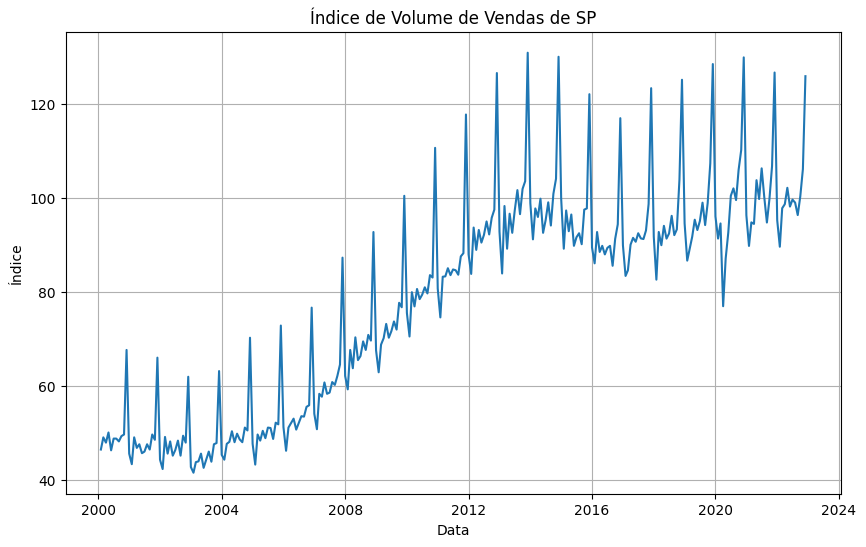

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(varejo2, label='Volume de Vendas - SP')
plt.title("Índice de Volume de Vendas de SP")
plt.xlabel('Data')
plt.ylabel('Índice')
plt.grid(True)
plt.show()

Divisão da série em treino e teste

In [8]:
varejotreino = varejo2[:'2020-12']
varejoteste = varejo2['2021-01':]

# Checagem do tamanho do conjunto de teste
print(f"Comprimento da série de teste: {len(varejoteste)}")

Comprimento da série de teste: 24


Plotando as séries de treino e teste juntas

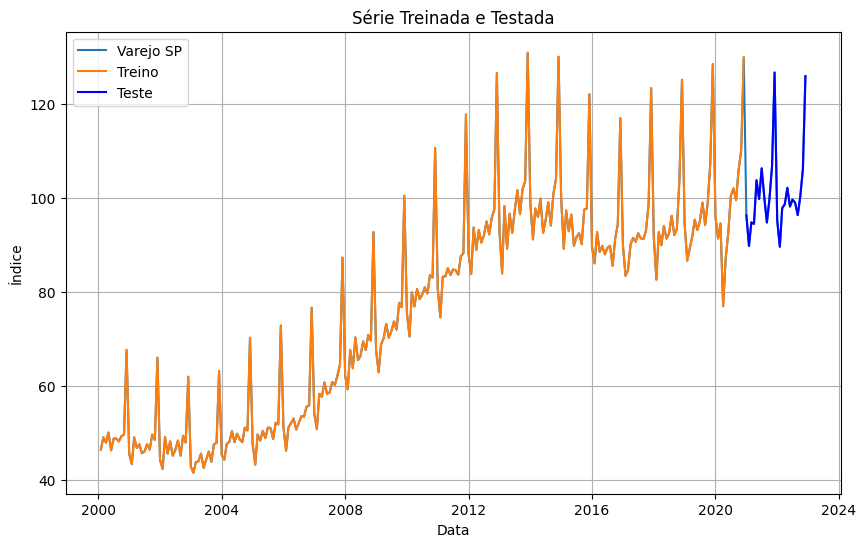

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(varejo2, label='Varejo SP')
plt.plot(varejotreino, label='Treino')
plt.plot(varejoteste, label='Teste', color='blue')
plt.title("Série Treinada e Testada")
plt.xlabel('Data')
plt.ylabel('Índice')
plt.legend()
plt.grid(True)
plt.show()

Análise da série

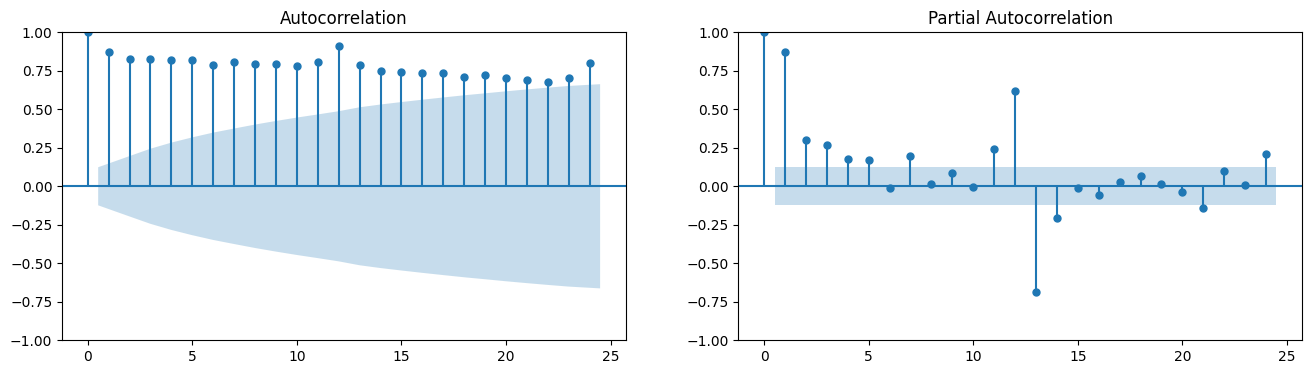

In [10]:
# Gráfico ACF e PACF
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(varejotreino, lags=24, ax=axes[0])
plot_pacf(varejotreino, lags=24, ax=axes[1], method='ywm')
plt.show()

Teste de Estacionariedade - ADF (Dickey-Fuller)

In [11]:
result = adfuller(varejotreino.dropna())
print(f'Resultado do Teste ADF: p-valor = {result[1]}')
if result[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

Resultado do Teste ADF: p-valor = 0.7577241262487042
A série não é estacionária.


Verificar quantas diferenciacoes sao necessarias

In [ ]:
verificar_differenciacao(varejotreino, "Varejo - Treinamento")


NameError: name 'pm' is not defined

Diferenciação para estacionariedade

In [15]:
varejotreino_diff = varejotreino.diff().dropna()

Gráficos ACF e PACF da série diferenciada

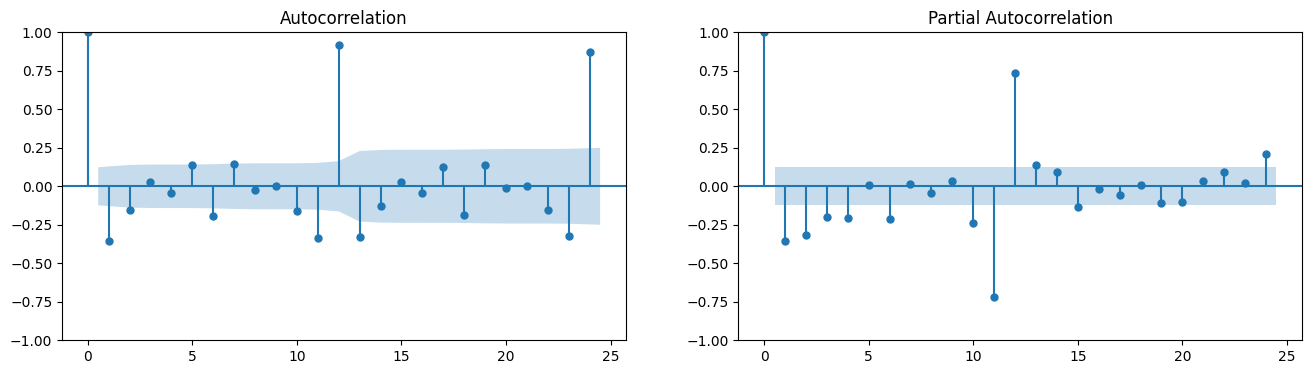

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(varejotreino_diff, lags=24, ax=axes[0])
plot_pacf(varejotreino_diff, lags=24, ax=axes[1], method='ywm')
plt.show()

Ajuste do modelo ARIMA na série diferenciada (autoarima)

In [17]:
arimavarejo = auto_arima(varejotreino_diff,
                         seasonal=True,
                         m=12,  # Periodicidade da sazonalidade
                         trace=True,
                         stepwise=True)

# Exibir o resumo do modelo ajustado
print(arimavarejo.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1118.389, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1198.862, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1143.323, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1121.154, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1196.871, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=1116.611, Time=0.41 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=1118.489, Time=0.66 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=1118.536, Time=0.37 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=1120.571, Time=1.05 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1115.056, Time=0.27 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=1116.803, Time=0.56 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=1116.909, Time=0.63 sec
 ARIMA(1,0,2)(1,1,0)[12] inte

 Validação e Diagnóstico

In [18]:
# Resíduos do modelo
residuos_arima = arimavarejo.resid()
print(f"Resíduos do modelo: {residuos_arima}")

Resíduos do modelo: Date
2000-03-01    2.590000
2000-04-01   -1.119992
2000-05-01    2.159999
2000-06-01   -3.799996
2000-07-01    2.499993
                ...   
2020-08-01    1.899014
2020-09-01    4.767294
2020-10-01    3.227023
2020-11-01   -0.550738
2020-12-01   -3.365002
Freq: MS, Length: 250, dtype: float64


Teste de Ljung-Box para verificar autocorrelação dos resíduos

In [19]:
ljung_box = sm.stats.acorr_ljungbox(residuos_arima, lags=[10], return_df=True)
print(f'Resultado do teste de Ljung-Box:\n{ljung_box}')
# Se p-value > 0.05, resíduos não são correlacionados

Resultado do teste de Ljung-Box:
     lb_stat  lb_pvalue
10  8.736144   0.557314


Teste de Normalidade dos Resíduos (Kolmogorov-Smirnov)

In [20]:

ks_stat, p_value = kstest(residuos_arima, 'norm', args=(np.mean(residuos_arima), np.std(residuos_arima)))
print(f'Teste de Kolmogorov-Smirnov para normalidade: p-valor = {p_value}')
if p_value > 0.01:
    print("Os resíduos seguem uma distribuição normal.")
else:
    print("Os resíduos não seguem uma distribuição normal.")

Teste de Kolmogorov-Smirnov para normalidade: p-valor = 0.0023016374984154253
Os resíduos não seguem uma distribuição normal.


Teste ARCH para verificar heterocedasticidade dos resíduos

In [21]:
am = arch_model(residuos_arima, vol='ARCH', p=1)
test_arch = am.fit(disp='off')
print(test_arch.summary())
#se p-value > 0.05 - nao ha efeitos ARCH

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -607.964
Distribution:                  Normal   AIC:                           1221.93
Method:            Maximum Likelihood   BIC:                           1232.49
                                        No. Observations:                  250
Date:                Tue, Nov 05 2024   Df Residuals:                      249
Time:                        23:15:30   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1561      0.152      1.026      0.305 [ -0.142,  0.45

Prever 24 passos à frente na série diferenciada

In [22]:
n_periods = 24
previsoes_diff = arimavarejo.predict(n_periods=n_periods)
print(f"Previsões diferenciadas: {previsoes_diff}")

Previsões diferenciadas: 2021-01-01   -31.122589
2021-02-01    -4.631158
2021-03-01     2.585956
2021-04-01    -9.293348
2021-05-01     6.747411
2021-06-01     3.104710
2021-07-01     4.884113
2021-08-01     2.654265
2021-09-01    -3.484563
2021-10-01     5.628580
2021-11-01     5.611917
2021-12-01    20.647417
2022-01-01   -31.512750
2022-02-01    -5.016421
2022-03-01     2.905550
2022-04-01    -9.558467
2022-05-01     6.967339
2022-06-01     2.922270
2022-07-01     5.035456
2022-08-01     2.528718
2022-09-01    -3.380417
2022-10-01     5.542186
2022-11-01     5.683585
2022-12-01    20.587965
Freq: MS, dtype: float64


Índices das previsões (mesmo formato de data da série de treino e teste)

In [23]:
index_of_fc = pd.date_range(varejotreino.index[-1], periods=n_periods+1, freq='MS')[1:]

Para voltar ao nível original:

In [24]:
# Iterar para reverter a diferenciação das previsões
ultimo_valor_original = varejotreino.iloc[-1] # Último valor conhecido da série original (não diferenciada)
previsoes_nivel_original = [ultimo_valor_original]
print(ultimo_valor_original)
print(previsoes_nivel_original)


volume_vendas    129.92
Name: 2020-12-01 00:00:00, dtype: float64
[volume_vendas    129.92
Name: 2020-12-01 00:00:00, dtype: float64]


Somar as previsões diferenciadas ao último valor conhecido da série original

In [25]:
for previsao in previsoes_diff:
    novo_valor = previsoes_nivel_original[-1] + previsao
    previsoes_nivel_original.append(novo_valor)

Remover o primeiro valor, pois é o último valor conhecido da série original

In [26]:
previsoes_nivel_original = previsoes_nivel_original[1:]
print(previsoes_nivel_original)

[volume_vendas    98.797411
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas    94.166252
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas    96.752208
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas    87.45886
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas    94.206271
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas    97.310981
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas    102.195094
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas    104.849358
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas    101.364795
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas    106.993375
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas    112.605292
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas    133.252709
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas    101.739959
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas    96.723537
Name: 2020-12-01 00:00:00, dtype: float64, volume_vendas

### Prevendo a Inflação - IPCA - BACEN

In [28]:
ipca = sgs.get({'ipca': 433}, start='2000-01-01', end='2024-08-31')
print(ipca)

            ipca
Date            
2000-01-01  0.62
2000-02-01  0.13
2000-03-01  0.22
2000-04-01  0.42
2000-05-01  0.01
...          ...
2024-04-01  0.38
2024-05-01  0.46
2024-06-01  0.21
2024-07-01  0.38
2024-08-01 -0.02

[296 rows x 1 columns]


Dividindo em série de treino (sipca) e teste (teste)

In [29]:
sipca = ipca[:'2023-08']
teste = ipca['2023-09':'2024-08']

Plotando as séries de treino e teste juntas

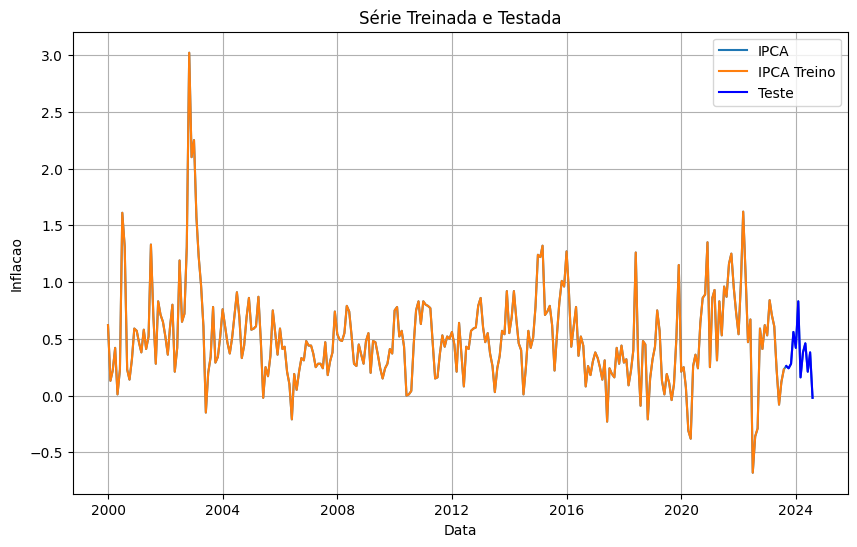

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(ipca, label='IPCA')
plt.plot(sipca, label='IPCA Treino')
plt.plot(teste, label='Teste', color='blue')
plt.title("Série Treinada e Testada")
plt.xlabel('Data')
plt.ylabel('Inflacao')
plt.legend()
plt.grid(True)
plt.show()


Criar colunas 'Ano' e 'Mês' a partir do índice de datas

In [31]:
import seaborn as sns

ipca['Ano'] = ipca.index.year
ipca['Mês'] = ipca.index.month

Fazer o Gráfico com destaque para valores mensais

C:\Users\naime\AppData\Local\Temp\ipykernel_19104\1860743567.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Mês', y='ipca', data=ipca, palette='viridis')


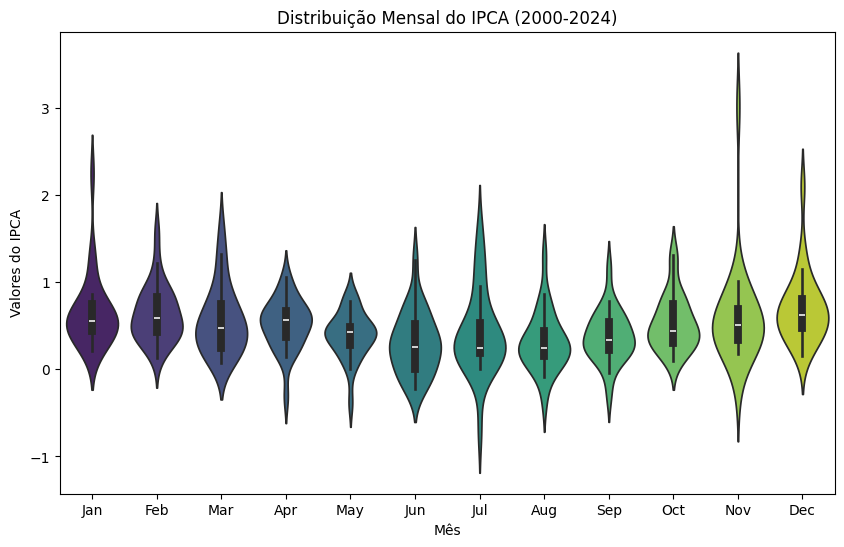

In [32]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Mês', y='ipca', data=ipca, palette='viridis')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Distribuição Mensal do IPCA (2000-2024)')
plt.xlabel('Mês')
plt.ylabel('Valores do IPCA')
plt.show()

Analisando a série com gráficos de ACF e PACF

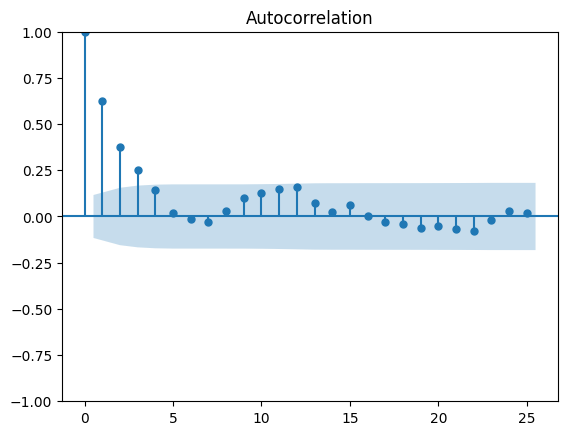

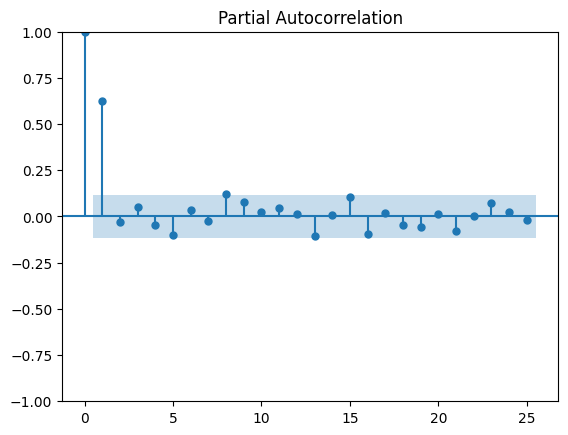

In [33]:
plot_acf(sipca)
plot_pacf(sipca, method='ywm')
plt.show()

Estimando o modelo ARIMA(1,0,0)(0,0,1)[12] com sazonalidade

In [34]:
# Certifique-se de que seu índice é um DatetimeIndex com frequência
sipca.index = pd.to_datetime(sipca.index)

# Se necessário, definir explicitamente a frequência, por exemplo, mensal ('MS')
sipca = sipca.asfreq('MS')  # MS é o padrão para início de cada mês

# Ajuste do modelo ARIMA com ordem sazonal
mod = ARIMA(sipca, order=(1, 0, 0), seasonal_order=(0, 0, 1, 12)).fit()

# Exibir o resumo do modelo ajustado
print(mod.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               ipca   No. Observations:                  284
Model:             ARIMA(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                 -70.803
Date:                            Tue, 05 Nov 2024   AIC                            149.607
Time:                                    23:15:31   BIC                            164.203
Sample:                                01-01-2000   HQIC                           155.458
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5066      0.061      8.263      0.000       0.386       0.627
ar.L1          0.6210      0.042   

Usando auto_arima para encontrar o melhor modelo

In [35]:
modelo = auto_arima(sipca, seasonal=True, m=12, trace=True)

# Fazendo a previsão do modelo com sazonalidade
pipca = mod.get_forecast(steps=12)
pipca_mean = pipca.predicted_mean

# Fazendo a previsão do modelo auto_arima
psipca = modelo.predict(n_periods=12)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=151.494, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=291.736, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=148.894, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=183.228, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=561.126, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=152.875, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=149.596, Time=0.45 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=145.956, Time=0.32 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=149.607, Time=0.15 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=147.939, Time=0.68 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=147.937, Time=0.81 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=150.458, Time=0.18 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=149.889, Time=1.26 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=288.013, Time=0.30 sec
 ARIMA(2,0,0)(1,0,1)[12] intercep

Plotando as previsões

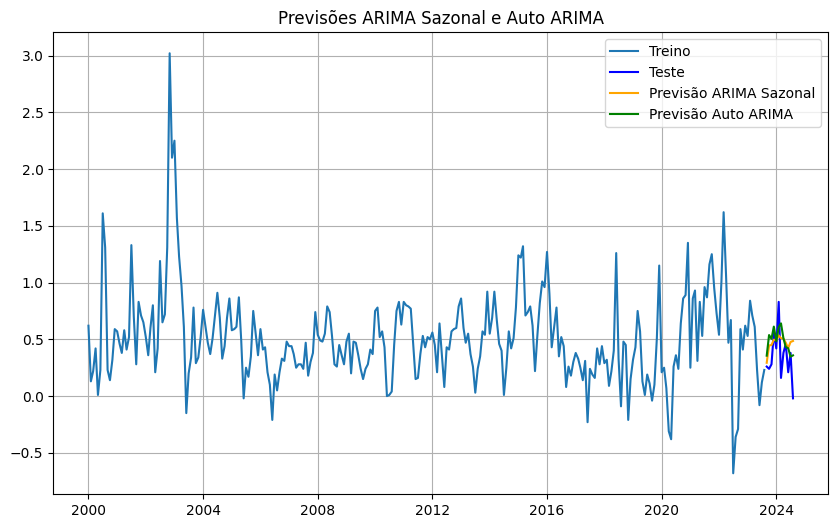

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(sipca, label='Treino')
plt.plot(teste, label='Teste', color='blue')
plt.plot(pd.Series(pipca_mean, index=teste.index), label='Previsão ARIMA Sazonal', color='orange')
plt.plot(pd.Series(psipca, index=teste.index), label='Previsão Auto ARIMA', color='green')
plt.legend()
plt.title('Previsões ARIMA Sazonal e Auto ARIMA')
plt.grid(True)
plt.show()


Fazendo o grafico somente com os valores previstos e reais

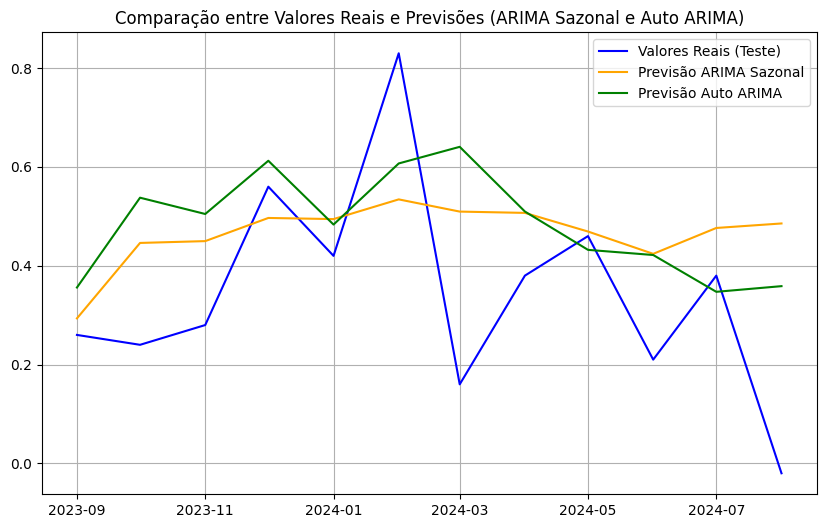

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(teste, label='Valores Reais (Teste)', color='blue')
plt.plot(pd.Series(pipca_mean, index=teste.index), label='Previsão ARIMA Sazonal', color='orange')
plt.plot(pd.Series(psipca, index=teste.index), label='Previsão Auto ARIMA', color='green')
plt.legend()
plt.title('Comparação entre Valores Reais e Previsões (ARIMA Sazonal e Auto ARIMA)')
plt.grid(True)
plt.show()

Avaliação da acurácia das previsões

In [38]:
mape_pipca = mean_absolute_percentage_error(teste, pipca_mean)*100
mape_psipca = mean_absolute_percentage_error(teste, psipca)*100
print(f'MAPE Previsão ARIMA Sazonal: {mape_pipca}')
print(f'MAPE Previsão Auto ARIMA: {mape_psipca}')

MAPE Previsão ARIMA Sazonal: 261.10432033701335
MAPE Previsão Auto ARIMA: 219.67778927778645


Verificando os resíduos

In [39]:
residuals = mod.resid

 agora que temos um modelo definido precisamos saber se o modelo capturou
 toda a estrutura do processo
 Significa que devemos checar se os resíduos do modelo estão limpos
 quer dizer, devemos ter resíduos não autocorrelacionados e normalmente
 distribuídos

Teste se os resíduos são não autocorrelacionados

In [40]:
# Teste de Ljung-Box
# H0: independência da ST, isto é, resíduos não correlacionados no tempo
# H1: dependência da ST, isto é, resíduos correlacionados, indicando que o
# modelo não capturou alguma estrutura que indica um erro sistemático
# Teste de Ljung-Box para independência dos resíduos

ljung_box = acorr_ljungbox(residuals, lags=[12], return_df=True)
print(ljung_box)

     lb_stat  lb_pvalue
12  8.353628   0.756921


In [41]:
# 2. Teste de Normalidade dos Resíduos
# Teste de Kolmogorv-Smirnov
# H0: Resíduos com comportamento normal
# H1: Resíduos sem normalidade

# Teste de normalidade dos resíduos (Kolmogorov-Smirnov)
ks_stat, ks_p_value = stats.kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))
print(f'Teste de Kolmogorov-Smirnov: p-value = {ks_p_value}')

Teste de Kolmogorov-Smirnov: p-value = 0.027323838000979372


Testar a estacionariedade da variância

In [42]:
## testar se existe efeitos ARCH
# H0: Não Existe Efeitos ARCH
# H1: Existe Efeitos ARCH
# Teste de efeitos ARCH nos resíduos
arch_test = arch_model(residuals,rescale=False).fit()
print(arch_test.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 11563.414323165398
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1248.684002647312
Iteration:      3,   Func. Count:     24,   Neg. LLF: 832.173574331075
Iteration:      4,   Func. Count:     30,   Neg. LLF: 54.25566415955666
Iteration:      5,   Func. Count:     36,   Neg. LLF: 53.532148833991386
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1235.6110756868625
Iteration:      7,   Func. Count:     49,   Neg. LLF: 50.294840497715626
Iteration:      8,   Func. Count:     55,   Neg. LLF: 49.842345944943006
Iteration:      9,   Func. Count:     61,   Neg. LLF: 49.83489639879353
Iteration:     10,   Func. Count:     66,   Neg. LLF: 49.83482682093672
Iteration:     11,   Func. Count:     71,   Neg. LLF: 49.83482597379803
Optimization terminated successfully    (Exit mode 0)
            Current function value: 49.83482597379803
            Iterations: 11
            Function evaluations: 71
            Gradient evaluations

Comparando agora as previsoes para a serie de energia com todos os modelos

In [43]:
# Capturar avisos de convergência e tratá-los
warnings.filterwarnings("error", category=ConvergenceWarning)

# Carregar os dados de energia e garantir que não há valores ausentes
energia = pd.read_excel("energia.xlsx", usecols=[1]).dropna()

Criar a série temporal a partir de 1979 com frequência mensal

In [44]:
energia.index = pd.date_range(start='1979-01', periods=len(energia), freq='M')
energia = energia.squeeze()  # Converter para uma Series

C:\Users\naime\AppData\Local\Temp\ipykernel_19104\2246842709.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  energia.index = pd.date_range(start='1979-01', periods=len(energia), freq='M')


Separar a base de dados em treino e teste

In [45]:
benergia = energia[:'2022-06'].ffill()  # Preencher valores nulos com forward fill
reaisenergia = energia['2022-07':'2024-06']  # Teste de 2022-07 até 2024-06

Converter explicitamente para tipo numérico e garantir que são floats

In [46]:
benergia = pd.to_numeric(benergia, errors='coerce').astype(float)

Lista para armazenar os modelos, MAPE e previsões

In [47]:
modelos_energia = []
mapes_energia = []
previsoes_energia = {}

Modelo Naive

In [53]:
naive_forecast = pd.Series([benergia.iloc[-1]] * len(reaisenergia), index=reaisenergia.index)
mape_naive = mape(reaisenergia, naive_forecast) * 100
modelos_energia.append("Naive")
mapes_energia.append(mape_naive)
previsoes_energia["Naive"] = naive_forecast


Modelo Mean (média)

In [55]:
mean_forecast = pd.Series(benergia.mean(), index=reaisenergia.index)
mape_mean = mape(reaisenergia, mean_forecast) * 100
modelos_energia.append("Mean")
mapes_energia.append(mape_mean)
previsoes_energia["Mean"] = mean_forecast


Modelo Drift

In [56]:
n = len(benergia)
drift_slope = (benergia.iloc[-1] - benergia.iloc[0]) / (n - 1)
drift_forecast = benergia.iloc[-1] + drift_slope * np.arange(1, len(reaisenergia) + 1)
drift_forecast = pd.Series(drift_forecast, index=reaisenergia.index)
mape_drift_result = mape(reaisenergia, drift_forecast) * 100
modelos_energia.append("Drift")
mapes_energia.append(mape_drift_result)
previsoes_energia["Drift"] = drift_forecast

Modelo Naive Sazonal

In [57]:
naive_sazonal_forecast = pd.Series([benergia.iloc[-12 + (i % 12)]
                                    for i in range(len(reaisenergia))],
                                   index=reaisenergia.index)
mape_naive_sazonal = mape(reaisenergia, naive_sazonal_forecast) * 100
modelos_energia.append("Naive Sazonal")
mapes_energia.append(mape_naive_sazonal)
previsoes_energia["Naive Sazonal"] = naive_sazonal_forecast

Suavização Exponencial Simples (SES)

In [58]:
ses_model = SimpleExpSmoothing(benergia).fit(optimized=True)
ses_forecast = ses_model.forecast(steps=len(reaisenergia))
mape_ses = mape(reaisenergia, ses_forecast) * 100
modelos_energia.append("SES")
mapes_energia.append(mape_ses)
previsoes_energia["SES"] = ses_forecast

Holt-Winters Aditivo - Ajustar inicialização e Box-Cox para melhorar a convergência

In [59]:
try:
    hw_add_model = ExponentialSmoothing(
        benergia,
        seasonal_periods=12,
        trend='add',
        seasonal='add',
        initialization_method="estimated",  # Método robusto de inicialização
        use_boxcox=True  # Tentar estabilizar a variância com Box-Cox
    ).fit(optimized=True)

    hw_add_forecast = hw_add_model.forecast(steps=len(reaisenergia))
    mape_hw_add = mape(reaisenergia, hw_add_forecast) * 100
    modelos_energia.append("Holt-Winters Aditivo")
    mapes_energia.append(mape_hw_add)
    previsoes_energia["Holt-Winters Aditivo"] = hw_add_forecast
except Exception:
    modelos_energia.append("Holt-Winters Aditivo")
    mapes_energia.append(np.nan)

Holt-Winters Multiplicativo - Ajustar inicialização e Box-Cox para melhorar a convergência

In [60]:
try:
    hw_mult_model = ExponentialSmoothing(
        benergia,
        seasonal_periods=12,
        trend='add',
        seasonal='mul',
        initialization_method="estimated",  # Método robusto de inicialização
        use_boxcox=True  # Tentar estabilizar a variância com Box-Cox
    ).fit(optimized=True)

    hw_mult_forecast = hw_mult_model.forecast(steps=len(reaisenergia))
    mape_hw_mult = mape(reaisenergia, hw_mult_forecast) * 100
    modelos_energia.append("Holt-Winters Multiplicativo")
    mapes_energia.append(mape_hw_mult)
    previsoes_energia["Holt-Winters Multiplicativo"] = hw_mult_forecast
except Exception:
    modelos_energia.append("Holt-Winters Multiplicativo")
    mapes_energia.append(np.nan)

Modelo ARIMA/SARIMA - Identificação automática

In [61]:
try:
    arima_model = auto_arima(benergia, seasonal=True, m=12, stepwise=True, trace=False, suppress_warnings=True)

    # Exibir o melhor modelo ARIMA/SARIMA encontrado
    print(f"Melhor modelo ARIMA/SARIMA identificado: {arima_model}")

    arima_forecast = pd.Series(arima_model.predict(n_periods=len(reaisenergia)), index=reaisenergia.index)
    mape_arima = mape(reaisenergia, arima_forecast) * 100
    modelos_energia.append("ARIMA/SARIMA")
    mapes_energia.append(mape_arima)
    previsoes_energia["ARIMA/SARIMA"] = arima_forecast
except Exception as e:
    print(f"Erro no modelo ARIMA/SARIMA: {e}")
    modelos_energia.append("ARIMA/SARIMA")
    mapes_energia.append(np.nan)

Melhor modelo ARIMA/SARIMA identificado:  ARIMA(1,1,1)(2,0,2)[12]          


Comparação dos modelos com base no MAPE

In [62]:
mape_comparison = pd.DataFrame({'Modelo': modelos_energia, 'MAPE': mapes_energia})
mape_comparison = mape_comparison.sort_values(by='MAPE', ascending=True).reset_index(drop=True)
print(mape_comparison)

                        Modelo       MAPE
0  Holt-Winters Multiplicativo   2.816250
1         Holt-Winters Aditivo   3.056556
2                 ARIMA/SARIMA   3.349548
3                Naive Sazonal   4.014128
4                        Drift   5.070079
5                          SES   5.672273
6                        Naive   6.583573
7                         Mean  34.551019


Gráfico dos MAPE dos modelos

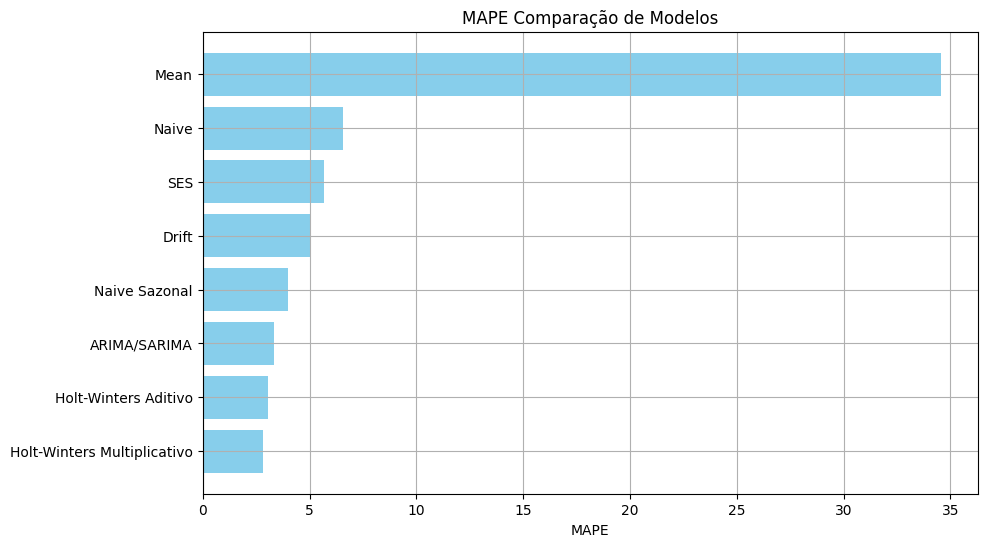

In [63]:
plt.figure(figsize=(10, 6))
plt.barh(mape_comparison['Modelo'], mape_comparison['MAPE'], color='skyblue')
plt.xlabel("MAPE")
plt.title("MAPE Comparação de Modelos")
plt.grid(True)
plt.show()


Selecionar o modelo com o menor MAPE

In [64]:
melhor_modelo = mape_comparison.loc[0, 'Modelo']
melhores_previsoes = previsoes_energia[melhor_modelo]

Criar gráfico comparando os valores reais e previstos do melhor modelo

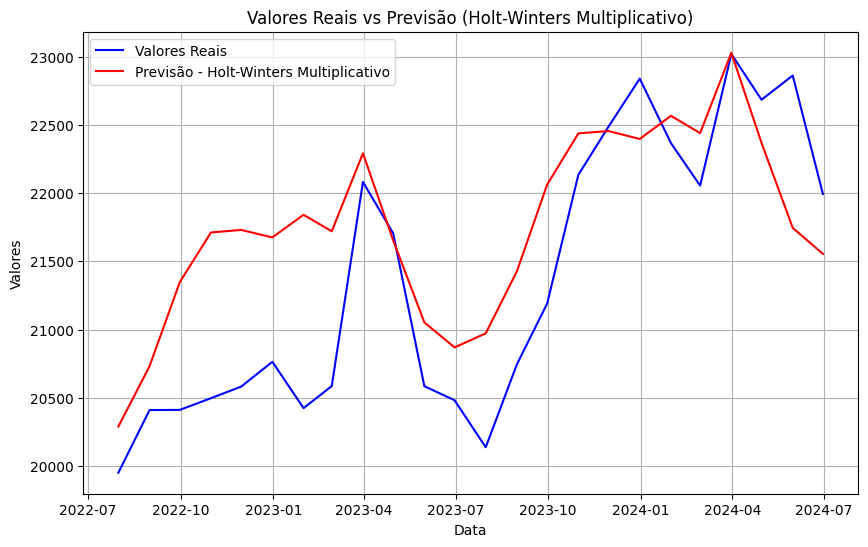

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(reaisenergia.index, reaisenergia, label='Valores Reais', color='blue')
plt.plot(reaisenergia.index, melhores_previsoes, label=f'Previsão - {melhor_modelo}', color='red')
plt.title(f'Valores Reais vs Previsão ({melhor_modelo})')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

Teste de normalidade e Ljung-Box para os resíduos do melhor modelo

In [66]:
residuos = reaisenergia - melhores_previsoes


Teste de normalidade Shapiro-Wilk

In [67]:
stat, p_value_shapiro = shapiro(residuos)
print(f"Teste de Normalidade Shapiro-Wilk: Estatística={stat:.4f}, p-valor={p_value_shapiro:.4f}")
if p_value_shapiro > 0.01:
    print("Os resíduos parecem seguir uma distribuição normal (não rejeitamos H0).")
else:
    print("Os resíduos não seguem uma distribuição normal (rejeitamos H0).")

Teste de Normalidade Shapiro-Wilk: Estatística=0.9710, p-valor=0.6907
Os resíduos parecem seguir uma distribuição normal (não rejeitamos H0).


Teste de Ljung-Box para autocorrelação dos resíduos

In [68]:
lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
print(f"Teste Ljung-Box:\n{lb_test}")


Teste Ljung-Box:
      lb_stat  lb_pvalue
10  19.611825   0.033145


Interpretação do teste de Ljung-Box

In [69]:
p_value_ljungbox = lb_test['lb_pvalue'].values[0]
if p_value_ljungbox > 0.01:
    print("Não há evidências de autocorrelação significativa nos resíduos (não rejeitamos H0).")
else:
    print("Há evidências de autocorrelação nos resíduos (rejeitamos H0).")

Não há evidências de autocorrelação significativa nos resíduos (não rejeitamos H0).
